In [92]:
#hide
#magic commands
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [167]:
#collapse-hide
#imports
from utils import *
import os
from pathlib import Path
import warnings
warnings.simplefilter('ignore')
import json
import io
import ast
import math
import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats, spatial
import seaborn as sns
import altair as alt

In [94]:
dataPath = Path('data/')
print(dataPath.absolute())

C:\Users\jsaur\Documents\git\tmdb5000\data


In [95]:
movies = pd.read_csv(dataPath/'tmdb_5000_movies.csv')
credits = pd.read_csv(dataPath/'tmdb_5000_credits.csv')

In [96]:
movies.shape

(4803, 20)

In [82]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [83]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


# Data Wrangling

By looking at the DataFrame above, we can already get an idea of the tasks we have to do. Certain features have data encoded inside a JSON object in a list, so we'll need to convert that into a suitable representation. We can also make assumptions about certain features, and drop certain features altogether without any tangible data loss. 

Let's get to it

## Removing `original_title` feature

We have two features related to title in the movie, namely `title` and `original_title`. There are however, a small number of cases when those two features aren't exactly the same (~6%) of the total dataset. A visual inspection tells us even in those cases, we can get the name of the movie by looking at `title` and `original_language` features. 

Considering we're trying to build a recommender system, the name of the movie is going to be one of the lease significant features(as I'll show later) and we can remove it from consideration.

In [104]:
movies[movies['original_title'] != movies['title']][['title', 'original_title', 'original_language']].head()

,title,original_title,original_language
97,Shin Godzilla,シン・ゴジラ,ja
215,Fantastic 4: Rise of the Silver Surfer,4: Rise of the Silver Surfer,en
235,Asterix at the Olympic Games,Astérix aux Jeux Olympiques,fr
317,The Flowers of War,金陵十三釵,zh
474,Evolution,Évolution,fr


In [105]:
movies = movies.drop('original_title', axis = 1)

In [109]:
movies['revenue'].describe()

count    4.803000e+03
mean     8.226064e+07
std      1.628571e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.917000e+07
75%      9.291719e+07
max      2.787965e+09
Name: revenue, dtype: float64

We can see above that roughly between 1/4 and 1/2 of the entries in our data have no `revenue`. While it may come across as a not so useful feature, we can use it later. For now, let's sanitize the zero values so we get some info out of it

In [111]:
movies['revenue'] = movies['revenue'].replace(0, math.nan)

In [120]:
movies['budget'].describe()

count    3.766000e+03
mean     3.704284e+07
std      4.264651e+07
min      1.000000e+00
25%      8.000000e+06
50%      2.300000e+07
75%      5.000000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [117]:
movies['budget'] = movies['budget'].replace(0, math.nan)

In [123]:
movies['return'] = movies['revenue'] / movies['budget']

In [128]:
movies['return'].describe()

count    3.229000e+03
mean     2.954822e+03
std      1.506101e+05
min      5.217391e-07
25%      1.022463e+00
50%      2.300366e+00
75%      4.420822e+00
max      8.500000e+06
Name: return, dtype: float64

Let's sanitize the year column

In [121]:
movies['year'] = pd.to_datetime(movies['release_date'], errors='coerce').apply(\
                lambda x: str(x).split('-')[0] if x != math.nan else math.nan)

In [122]:
movies.head()

,budget,genres,homepage,id,keywords,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,year
0,237000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2.787965e+09,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,2009
1,300000000.0,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,9.610000e+08,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,2007
2,245000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,8.806746e+08,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,2015
3,250000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1.084939e+09,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,2012
4,260000000.0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,2.841391e+08,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,2012


# EDA
Let's move on to do some data analysis, build world clouds and more!

In [129]:
movies['title'] = movies['title'].astype('str')
movies['overview'] = movies['overview'].astype('str')

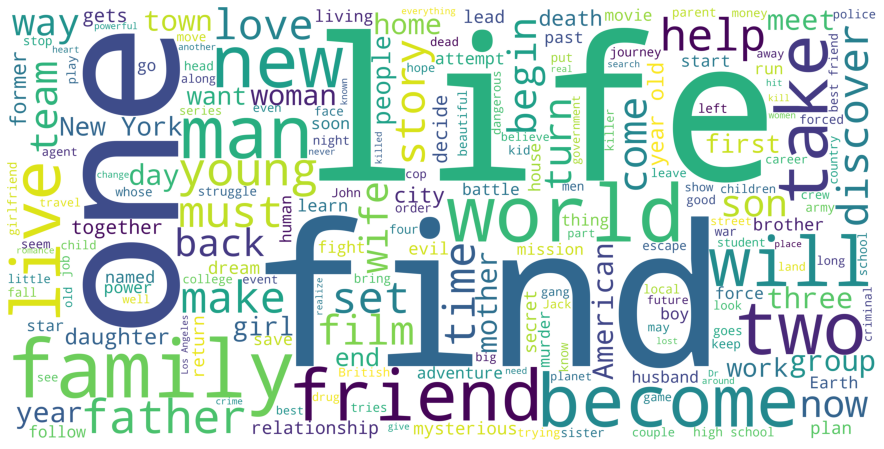

In [132]:
from wordcloud import WordCloud, STOPWORDS
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(''.join(movies['overview']))
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

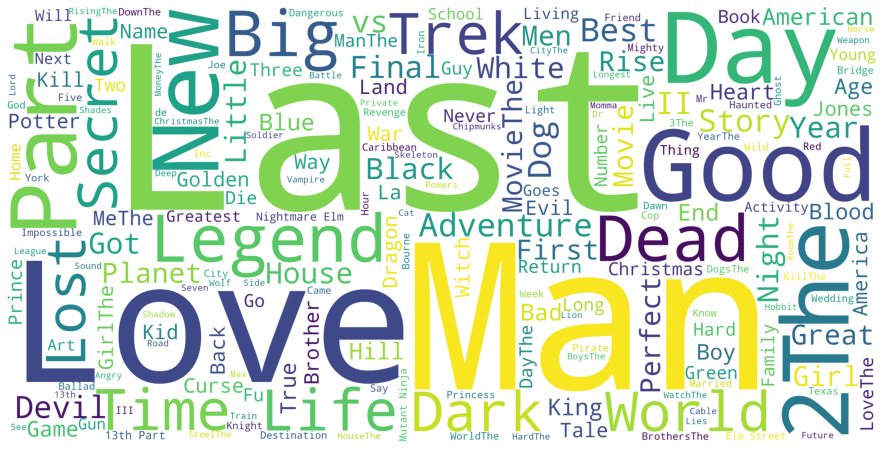

In [133]:
from wordcloud import WordCloud, STOPWORDS
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(''.join(movies['title']))
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

## Languages

Let's look into the languages of the movies available in the dataset

In [146]:
movies['original_language'].drop_duplicates().shape

(37,)

There are 37 different languages, that's a wide range. Let's plot the occurence of each language

In [158]:
languages = pd.DataFrame(movies['original_language'].value_counts())
languages['language'] = languages.index
columns = ['num', 'language']
languages.columns = columns

In [159]:
languages.head()

,num,language
en,4505,en
fr,70,fr
es,32,es
de,27,de
zh,27,zh


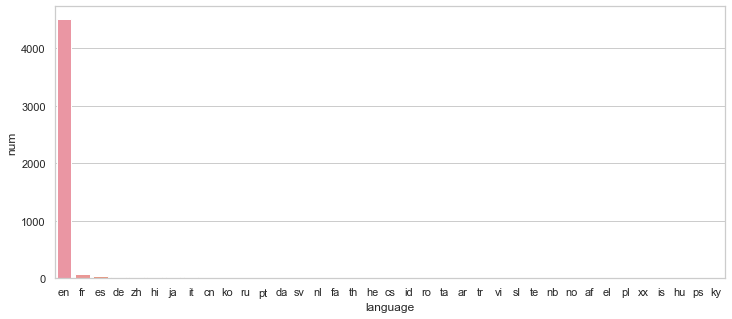

In [163]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,5))
sns.barplot(x = 'language', y = 'num', data = languages)
plt.show()

Let's look at a graph that makes it a bit easier for us to visualize the different languages present in the dataset

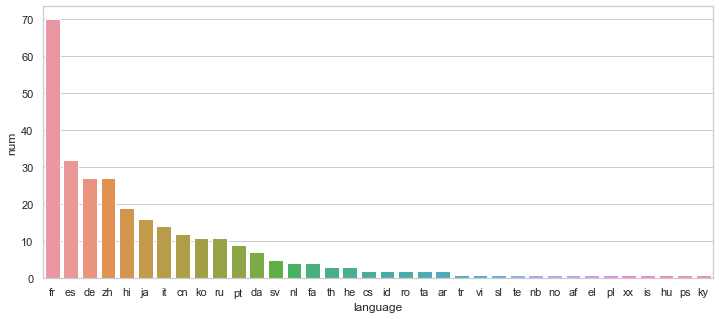

In [164]:
sns.set(style="whitegrid")
plt.figure(figsize=(12,5))
sns.barplot(x = 'language', y = 'num', data = languages.iloc[1:])
plt.show()

Amongst all the features, we could be looking at or creating, perhaps few are as important as time of release. When a movie is released tends to have a strong correlation with how well it does. Major franchisee movies tend to be released around the time of holidays/summer months. Conversely, movies released around the time of holidays go on to do a lot better than those released around the year. Let's try to plot this distribution

In [165]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [166]:
def get_month(x):
    try:
        return months[int(str(x).split('-')[1]) - 1]
    except:
        return math.nan

In [168]:
def get_day(x):
    try:
        y,m,d = (int(i) for i in x.split('-'))    
        return days[datetime.date(year, month, day).weekday()]
    except:
        return np.nan

In [169]:
movies['day'] = movies['release_date'].apply(get_day)
movies['month'] = movies['release_date'].apply(get_month)

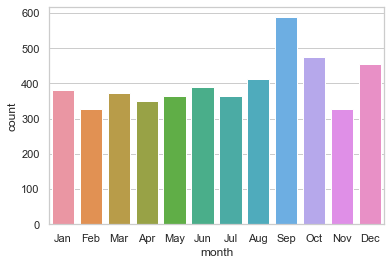

In [170]:
sns.countplot(x = 'month', data = movies, order = months)

In [171]:
print(movies['revenue'].describe())

count    3.376000e+03
mean     1.170314e+08
std      1.834831e+08
min      5.000000e+00
25%      1.535290e+07
50%      5.175184e+07
75%      1.401651e+08
max      2.787965e+09
Name: revenue, dtype: float64


The mean revenue for movies in our dataset is 1.170314e+08. Let's now try to plot only the release dates of the movies whose revenue is greater than the mean for the data.

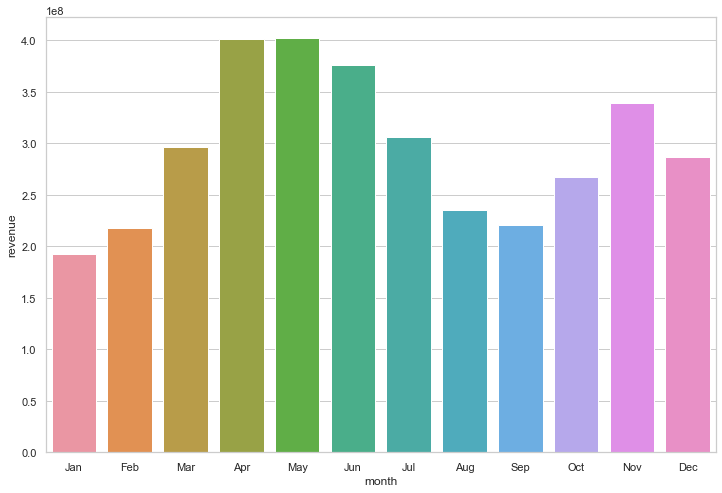

In [175]:
means = pd.DataFrame(movies[movies['revenue'] > 1.17e8].groupby('month')['revenue'].mean())
means['month'] = means.index
plt.figure(figsize=(12,8))
# plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x = 'month', y = 'revenue', data = means, order = months)

From the chart above, we can see that the months of summer have the most number of movies who fare better than the numerically average movie in the dataset.

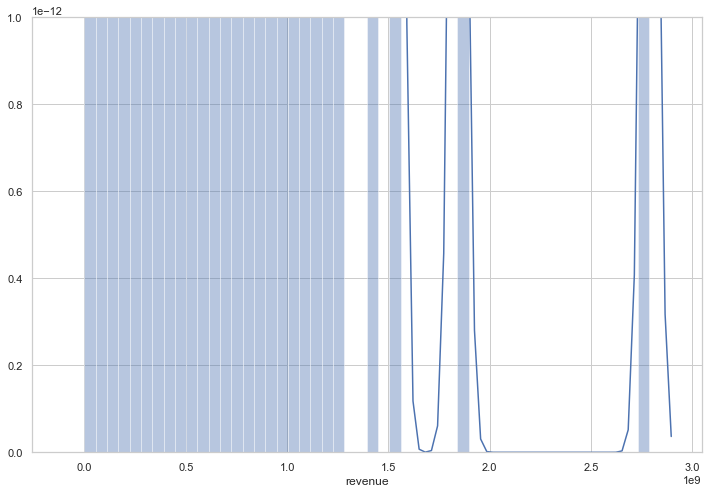

In [179]:
plt.figure(figsize=(12,8))
sns.distplot(movies[movies['revenue'].notnull()]['revenue'])

In [183]:
gross_top = movies[['title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False)
pd.set_option('display.max_colwidth', 100)
gross_top.head()

,title,budget,revenue,year
0,Avatar,237000000.0,2.787965e+09,2009
25,Titanic,200000000.0,1.845034e+09,1997
16,The Avengers,220000000.0,1.519558e+09,2012
28,Jurassic World,150000000.0,1.513529e+09,2015
44,Furious 7,190000000.0,1.506249e+09,2015


# Modeling

## Convert JSON to List

In [91]:
features = ['keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].fillna('[]').apply(ast.literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])